# Exploratory Data Analysis (EDA)

> Dataset: https://www.kaggle.com/datasets/kutlayusta/type-of-rocks-and-minerals-dataset/data

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from PIL import Image
from torchvision import transforms
import random

## Data Loading and Basic Information

Total images: 10830
Images per class: {'igneous': 3848, 'metamorphic': 3851, 'sedimentary': 3131}


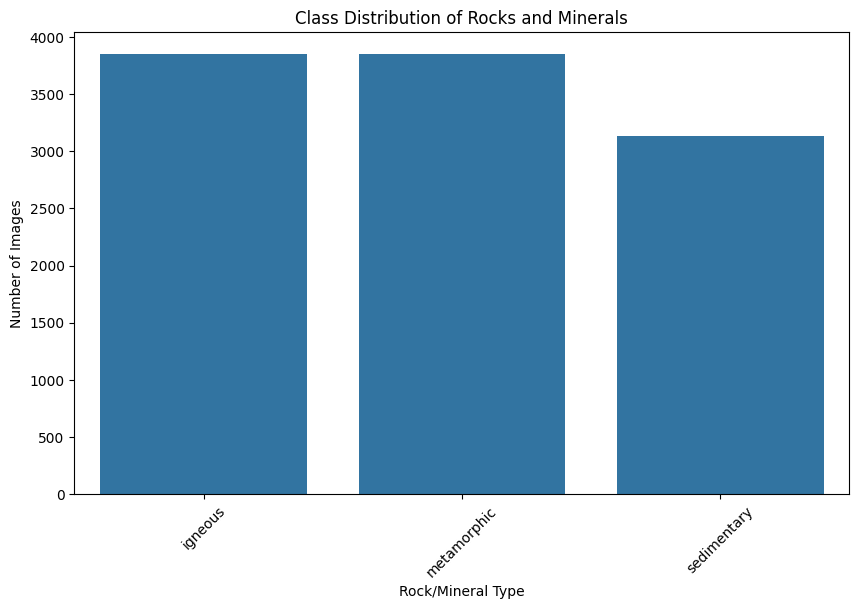

In [2]:
# Define dataset directory path
data_dir = "Rocks_Dataset"
classes = os.listdir(data_dir)

# Get total number of images and count per class
class_counts = {}

for rock_type in classes:
    class_folder = os.path.join(data_dir, rock_type)
    class_counts[rock_type] = len(os.listdir(class_folder))

# Display total images and distribution per class
image_count = sum(class_counts.values())

print(f"Total images: {image_count}")
print("Images per class:", class_counts)

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.xlabel('Rock/Mineral Type')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Rocks and Minerals')
plt.show()

## Data Quality Analysis

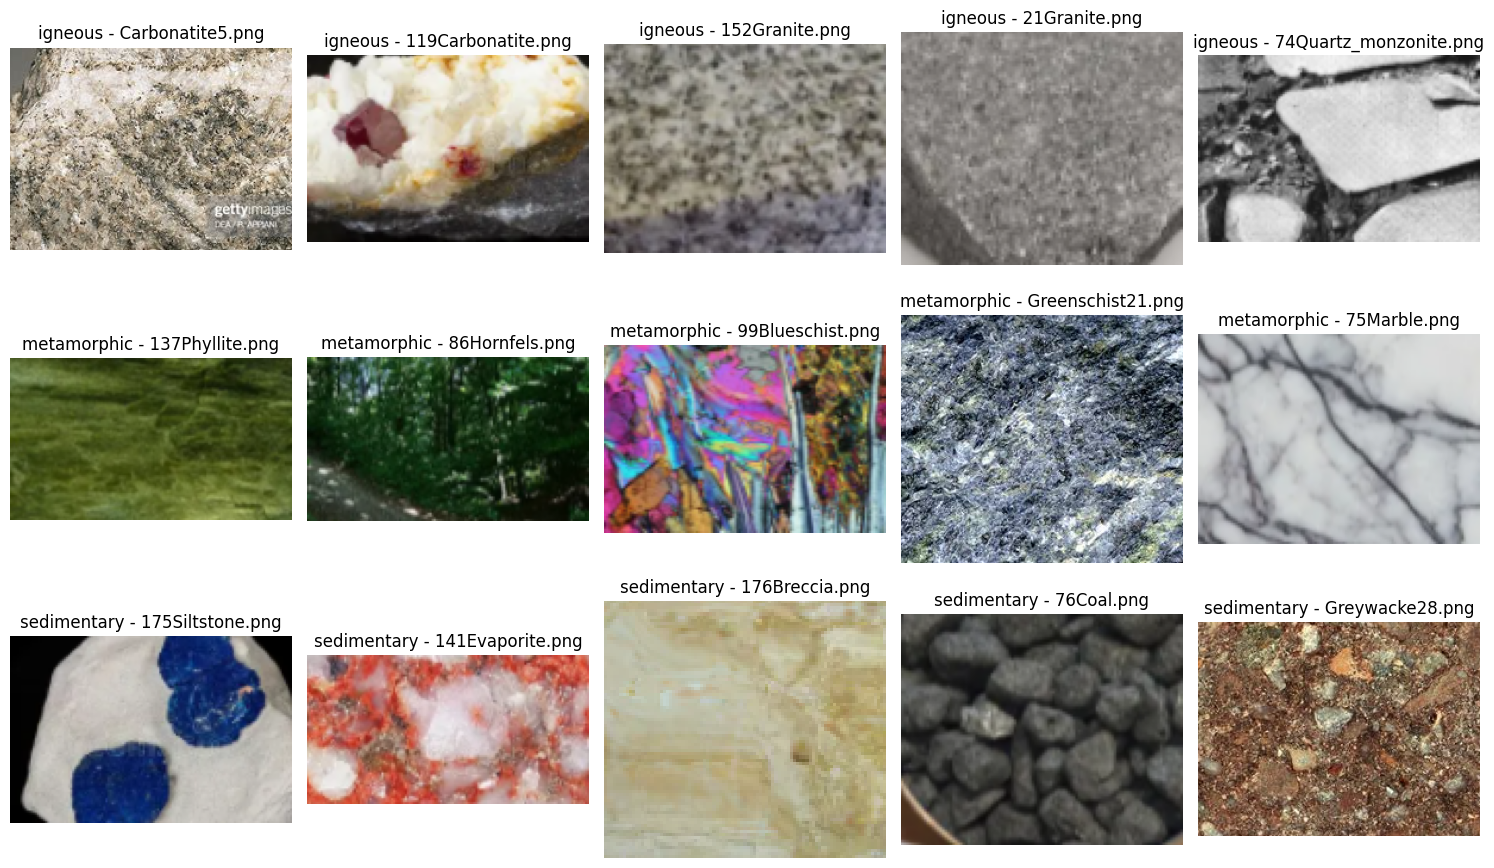

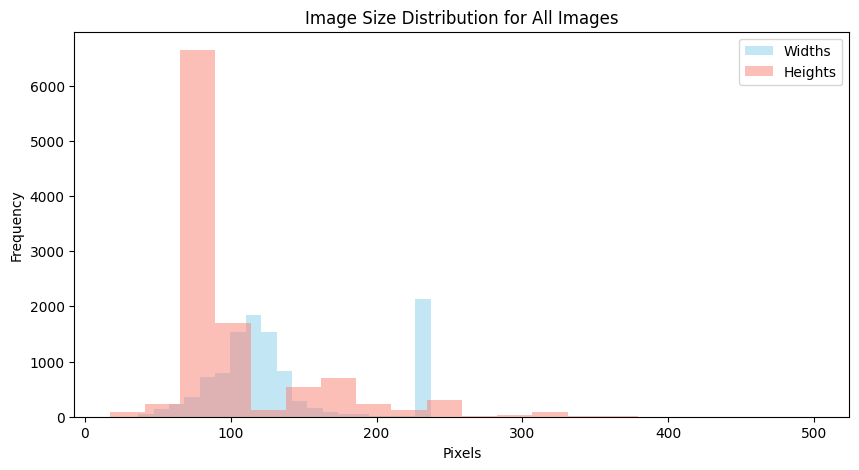

Average Image Size: [136.57, 104.03]


In [3]:
# Check image resolution and quality consistency

# Display 5 random images from each class in a grid
fig, axs = plt.subplots(len(classes), 5, figsize=(15, len(classes) * 3))

for i, rock_type in enumerate(classes):
    class_folder = os.path.join(data_dir, rock_type)
    image_files = os.listdir(class_folder)
    
    # Randomly select 5 images from each class
    selected_images = random.sample(image_files, 5)
    
    for j, image_name in enumerate(selected_images):
        image_path = os.path.join(class_folder, image_name)
        with Image.open(image_path) as img:
            axs[i, j].imshow(img)
            axs[i, j].set_title(f"{rock_type} - {image_name}")
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

# Collect image sizes for all images in the dataset
image_sizes = []

for rock_type in classes:
    class_folder = os.path.join(data_dir, rock_type)
    image_files = os.listdir(class_folder)
    
    for image_name in image_files:
        image_path = os.path.join(class_folder, image_name)
        
        with Image.open(image_path) as img:
            image_sizes.append(img.size)

# Extract widths and heights from all image sizes
widths, heights = zip(*image_sizes)

# Plot the image size distribution
plt.figure(figsize=(10, 5))
plt.hist(widths, bins=20, alpha=0.5, label='Widths', color='skyblue')
plt.hist(heights, bins=20, alpha=0.5, label='Heights', color='salmon')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Image Size Distribution for All Images')
plt.legend()
plt.show()

print(f"Average Image Size: [{statistics.mean(widths):.2f}, {statistics.mean(heights):.2f}]")

## Data Imbalance Analysis

*Identification:*
Based on the distribution chart, it is evident that the **sedimentary** class is slightly imbalanced (3131) compared to the **igneous** (3848) and **metamorphic** (3851) classes. Despite the difference not being drastic, the imbalance could potentially affect model performance, leading to poor recognition of the underrepresented sedimentary class.

*Mitigation:*
To resolve this issue, the strategy of under-sampling the igneous and metamorphic classes will be used. All classes will be randomly trimmed to a size of **3131** to ensure bias is not present. This method was chosen over data augmentation due to time constraints and available computational resources.

## Data Augmentation Analysis

*Technique:*
- Resize Image
    - Define target size
    - Define function to apply augmentation
    - Utilize function
- Enhance Image
    - Define transformations
        - **ColorJitter** from torchvision.transforms for brightness and contrast
        - **RandomAdjustSharpness** from torchvision.transforms for sharpness filter

*Implementation:*

In [4]:
# Set the target size for resizing
target_size = (120, 120)

# Define function to resize images in a directory
def resize_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)

        os.makedirs(output_class_path, exist_ok=True)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            output_image_path = os.path.join(output_class_path, image_name)

            with Image.open(image_path) as img:
                img_resized = img.resize(target_size, Image.Resampling.LANCZOS)

                img_resized.save(output_image_path)

# Set dataset paths
input_directory = "Rocks_Dataset"
resized_directory = "Resized_Rocks_Dataset"

# Resize images
resize_images(input_directory, resized_directory)
print("All images have been resized to 120x120.")

# Define transformations for enhancing image quality
enhance_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.3),           # Adjust brightness and contrast
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=1.0),    # Sharpen the image
])

# Define function to apply enhancements to resized images
def enhance_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)

        os.makedirs(output_class_path, exist_ok=True)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            output_image_path = os.path.join(output_class_path, image_name)

            with Image.open(image_path) as img:
                # Convert image to RGB if not already (ensures compatibility with `transforms.Compose`)
                img = img.convert("RGB")
                
                # Apply enhancement transformations
                enhanced_img = enhance_transform(img)
                
                # Save the enhanced image
                enhanced_img.save(output_image_path)

# Set enhanced dataset path
enhanced_directory = "Enhanced_Rocks_Dataset"

# Enhance the resized images
enhance_images(resized_directory, enhanced_directory)
print("All images enhanced to improve quality.")

All images have been resized to 120x120.
All images enhanced to improve quality.


## Summary of Findings

### Class Imbalance
While there are no **significantly** underrepresented classes, **under-sampling** will be employed to equalize the class distributions before splitting. This will improve the model's learning potential, while also saving time and computational resources.

### Size Consistency
The image size distribution chart shows that there are variations in image resolution, with a significant number of images differing in their pixel dimensions. To address this all images were resized to the uniform size of **120x120 pixels** (the average square image size for the dataset), to ensure consistency, improve stability and reduce computational complexity during model training.

### Image Quality
Based on visual inspection, some images could potentially have a negative impact on training (e.g., blurry or inconsistent resolution), which would only be exacerbated after image resizing. In order to maintain consistent quality, the images had a **sharpening filter** applied to improve clarity and had the **brightness** and **contrast** adjusted to make images more vivid.